# Using Encoding and Pruning to Solve CovType Problem

+ apply pruning ANN to covtype problem. 
+ Compare the full network and pruned network
+ study the effect of similarity/complementary angle thresholds


##### Hongbo Zhang

In [1]:
import torch
import gzip
import io
import time
import numpy as np
import torch.utils.data as Data
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
import copy

In [2]:
# define architecture from pruning.ipynb

# architecture

class PruningANN(torch.nn.Module):
    '''a simple three layer full connected ANN'''
    def __init__(self, nin, nh, nout=7):
        '''
        nin is number of input feature.
        nh is number of neuron in hidden layer.
        nout equals to the number of categories,
        default is 7 in covtype classification problem.
        '''
        super(PruningANN, self).__init__()
        # attributes
        self.nin = nin
        self.nh = nh
        self.nout = nout
        self.hiddenOut = torch.FloatTensor([])  # output of hidden neuron
        self.distinctiveness = torch.FloatTensor([]) # distinctiveness between two hidden neurons
        # two module object
        self.hidden = torch.nn.Linear(nin, nh)   # hidden 1
        self.outlayer = torch.nn.Linear(nh, nout)    # output layer
        
    def forward(self, x):
        # forward calulation
        hiddenIn = self.hidden(x) 
        # hiddenOut = F.relu(hiddenIn)
        hiddenOut = F.sigmoid(hiddenIn)
        outIn = self.outlayer(hiddenOut)
        out = F.sigmoid(outIn) # map to [0,1] for classification
        # store the output of hidden neurons to an array
        # used for later distinctiveness calculation
        self.hiddenOut = hiddenOut.data
        return out
    
    def getHiddenOut(self):
        '''
        get output value of hidden layer
        this function can be called only after `forward`
        size: n_pattern (row) * nh (col)
              where n_pattern is row of x in forward(x)
        '''
        return self.hiddenOut
    
    def getHiddenWeight(self):
        '''
        get weight between hidden layer and output layer (nh by nout)
        only get list(self.outlayer.parameters())[0],
        since list(self.outlayer.parameters())[1] is bias,
        size: nout * nh  (NOT nh * nout)
        '''
        return list(self.outlayer.parameters())[0].data # only return [0], since [1] is bias
        
    def getInputWeight(self):
        '''
        get weight between input layer and hidden layer (nin by nh)
        size: nh * nin (NOT nin * nh)
        '''
        return list(self.hidden.parameters())[0].data
        
    def constHidden(self, threshold):
        '''
        find all the hidden neurons that its max output - min output < threshold
        '''
        res = []
        num = self.hiddenOut.size()[1]
        for i in range(num):
            maxout = max(self.hiddenOut[:,i])
            minout = min(self.hiddenOut[:,i])
            print("the ", i, "-th hidden neuron: max ", maxout, ", min: ", minout)
            if (maxout - minout) < threshold:
                res.append(i)
        return res
    
    def removeOneConstNeuron(self, index):
        '''
        remove the constant neuron, and adjust bias
        1. adjust bias
        2. remove the index-th column in self.hiddenOut
        3. remove the index-th column in hiddenWeight: list(self.outlayer.parameters())[0].data
        4. remove the index-th row in inputWeight: list(self.hidden.parameters())[0].data
        5. remove the index-th row in bias of input: list(self.hidden.parameters())[1].data
        '''
        num = self.hiddenOut.size()[1]
        perserveInd = torch.from_numpy(np.delete(np.arange(num), np.array([index]))).type(torch.LongTensor)
        # 4. adjust bias of output neuron: list(self.outlayer.parameters())[1].data
        #          adding mean(self.hiddenOut[:, index])*(its weight to output neuron)
        meanval = torch.mean(self.hiddenOut[:, index])
        list(self.outlayer.parameters())[1].data += meanval * list(self.outlayer.parameters())[0].data[:, index]
        # 1. remove the index-th column in self.hiddenOut
        self.hiddenOut = self.hiddenOut[:, perserveInd]
        # 2. remove the index-th column in hiddenWeight: list(self.outlayer.parameters())[0].data
        list(self.outlayer.parameters())[0].data = list(self.outlayer.parameters())[0].data[:, perserveInd]
        # 3. remove the index-th row in the inputWeight: list(self.hidden.parameters())[0].data
        list(self.hidden.parameters())[0].data = list(self.hidden.parameters())[0].data[perserveInd,:]
        # 5. remove the index-th row in bias of input: list(self.hidden.parameters())[1].data
        list(self.hidden.parameters())[1].data = list(self.hidden.parameters())[1].data[perserveInd]
        # don't modify the grad in Variable
        
    def removeAllConstNeuron(self, threshold):
        '''remove all const neuron in array'''
        array = self.constHidden(threshold)
        array.sort(reverse=True)
        counter = 0
        for ind in array:
            self.removeOneConstNeuron(ind)
            counter += 1
        print("Has remove ", counter, " constant neurons.")
    
    def getDistinctiveness(self):
        '''find distinctiveness between two hidden neurons'''
        num = self.hiddenOut.size()[1]
        hout = self.hiddenOut - 0.5
        res = []
        for i in range(num):
            vec1 = hout[:,i]
            for j in range(i):
                vec2 = hout[:,j]
                ang = math.acos(torch.matmul(vec1, vec2)/math.sqrt(torch.matmul(vec1,vec1))/math.sqrt(torch.matmul(vec2,vec2)))
                res.append([i,j,ang*180/3.14])
        return res
    
    def similarity(self, angle = 15):
        '''distinctiveness < angle (15 by default) degree'''
        angleArr = np.array(self.getDistinctiveness())
        mask = np.where(angleArr[:,2] < angle)
        return angleArr[mask, 0:2][0]
    
    def complementary(self, angle = 165):
        '''distinctiveness > angle (165 by default) degree'''
        angleArr = np.array(self.getDistinctiveness())
        mask = np.where(angleArr[:,2] > angle)
        return angleArr[mask, 0:2][0]
    
    def removeOneSimilarPair(self, ind1, ind2):
        '''
        remove one neuron in similarity pair. remove ind1, perserve ind2
        1. adjust weights of ind1 to ind2
        2. remove the ind1-th column in self.hiddenOut
        3. remove the ind1-th column in hiddenWeight: list(self.outlayer.parameters())[0].data
        4. remove the ind1-th row in inputWeight: list(self.hidden.parameters())[0].data
        5. remove the index-th row in bias of input: list(self.hidden.parameters())[1].data
        '''
        num = self.hiddenOut.size()[1]
        perserveInd = torch.from_numpy(np.delete(np.arange(num), np.array([ind1]))).type(torch.LongTensor)
        # 1. adjust weight of un-removed neuron: list(self.outlayer.parameters())[0].data[:, ind2]
        #          adding list(self.outlayer.parameters())[0].data[:, ind1] 
        list(self.outlayer.parameters())[0].data[:, ind2] += list(self.outlayer.parameters())[0].data[:, ind1]
        # 2. remove the ind1-th column in self.hiddenOut
        self.hiddenOut = self.hiddenOut[:, perserveInd]
        # 3. remove the ind1-th column in hiddenWeight: list(self.outlayer.parameters())[0].data
        list(self.outlayer.parameters())[0].data = list(self.outlayer.parameters())[0].data[:, perserveInd]
        # 4. remove the ind1-th row in inputWeight: list(self.hidden.parameters())[0].data
        list(self.hidden.parameters())[0].data = list(self.hidden.parameters())[0].data[perserveInd,:]
        # 5. remove the ind1-th row in bias of input: list(self.hidden.parameters())[1].data
        list(self.hidden.parameters())[1].data = list(self.hidden.parameters())[1].data[perserveInd]
    
    def removeAllSimilarPair(self, angle = 15):
        '''remove the similar neuron pairs'''
        simlist = self.similarity(angle)
        counter = 0
        while simlist.shape[0] != 0:
            ind1 = simlist[0, 0]
            ind2 = simlist[0, 1]
            self.removeOneSimilarPair(int(ind1), int(ind2))
            simlist = self.similarity(angle)
            counter += 1
        print("Has remove ", counter, " similarity neurons.")
    
    def removeOneComplementaryPair(self, ind1, ind2):
        '''
        remove one complementary pair, and adjust weight
        1. remove the ind1-th and ind2-th column in self.hiddenOut
        2. remove the ind1-th and ind2-th column in hiddenWeight: list(self.outlayer.parameters())[0].data
        3. remove the ind1-th and ind2-th row in inputWeight: list(self.hidden.parameters())[0].data
        4. remove the index-th row in bias of input: list(self.hidden.parameters())[1].data
        '''        
        num = self.hiddenOut.size()[1]
        perserveInd = torch.from_numpy(np.delete(np.arange(num), np.array([ind1, ind2]))).type(torch.LongTensor)
        # 1. remove the ind1-th and ind2-th column in self.hiddenOut
        self.hiddenOut = self.hiddenOut[:, perserveInd]
        # 2. remove the ind1-th and ind2-th column in hiddenWeight: list(self.outlayer.parameters())[0].data
        list(self.outlayer.parameters())[0].data = list(self.outlayer.parameters())[0].data[:, perserveInd]
        # 3. remove the ind1-th and ind2-th row in the inputWeight: list(self.hidden.parameters())[0].data
        list(self.hidden.parameters())[0].data = list(self.hidden.parameters())[0].data[perserveInd,:]
        # 4. remove the index-th row in bias of input: list(self.hidden.parameters())[1].data
        list(self.hidden.parameters())[1].data = list(self.hidden.parameters())[1].data[perserveInd]
    
    def removeAllComplementaryPair(self, angle=165):
        '''remove all complementary neuron pair in indlist, and adjust weight'''
        complist = self.complementary(angle)
        counter = 0
        while complist.shape[0] != 0:
            ind1 = complist[0, 0]
            ind2 = complist[0, 1]
            self.removeOneComplementaryPair(int(ind1), int(ind2))
            complist = self.complementary(angle)
            counter += 1
        print("Has remove ", 2*counter, " complementary neurons.")
        
    def pruning(self, constThreshold=0.1, similarThreshold=15, complementThreshold=165):
        '''
        1. remove const neuron
        2. remove complementary
        3. remove similarity
        '''
        self.removeAllConstNeuron(constThreshold)
        self.removeAllComplementaryPair(complementThreshold)
        self.removeAllSimilarPair(similarThreshold)


In [3]:
# hyper parameters
EPOCH = 20
BATCHSIZE = 290
LR = 0.01
ISGPU = False

Has read to line:  100000
Has read to line:  200000
use time:  2.8806865215301514  to read data file.


Columns 0 to 9 
 0.5728  0.5026 -0.8645  0.2424  0.0608  0.2196  0.7944  0.7323  0.0000  0.9882
 0.5388 -0.3258  0.9454  0.1515  0.1933  0.2416  0.5868  0.9331  0.0000  0.9094

Columns 10 to 19 
 0.0000  0.7913  0.3668  1.0000  0.0000  0.0000  0.0000  0.8333  1.0000  0.5000
 0.0000  0.4843  0.6142  1.0000  0.0000  0.0000  0.0000  0.3333  1.0000  0.4889
[torch.FloatTensor of size 2x20]


 0
 1
[torch.LongTensor of size 2]

Has read to line:  100000
use time:  1.3893132209777832  to read data file.
Variable containing:

Columns 0 to 9 
 0.3687  0.7422  0.6702  0.0455  0.1847  0.2235  0.0717  0.8701  0.0000  0.9134
 0.3657  0.8532 -0.5216  0.0303  0.1518  0.2158  0.0548  0.8661  0.0000  0.9252

Columns 10 to 19 
 0.0000  0.5827  0.8754  1.0000  0.0000  0.0000  0.0000  0.8333  1.0000  0.5000
 0.0000  0.5945  0.8678  1.0000  0.0000  0.0000  0.0000  0.8333  1.0000  0.5000
[torch.FloatTenso

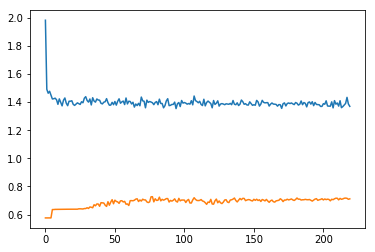

In [4]:
# training data of complex encoding

comtrainfilepath = gzip.open("../data/traincom.data.gz", 'rb')

comtrainfile = io.BufferedReader(comtrainfilepath)

ndata = 581012/2
xytrainCom = np.empty((int(ndata),21))

start = time.time()
i = 0
for line in comtrainfile:
    xytrainCom[i] = np.fromstring(line, dtype=float, sep=",")
    i += 1;
    if i % 100000 == 0:
        print("Has read to line: ", i)
end = time.time()
            

print("use time: ", end-start, " to read data file.")
comtrainfile.close()

xtrainCom = torch.from_numpy(xytrainCom[:, :-1]).type(torch.FloatTensor)
ytrainCom = torch.from_numpy(xytrainCom[:, -1] - 1).type(torch.LongTensor)

print(xtrainCom[:2])
print(ytrainCom[:2])

# testing data of complex encoding

comtestfilepath = gzip.open("../data/testcom.data.gz", 'rb')

comtestfile = io.BufferedReader(comtestfilepath)

ndata = 581012/2/2
xytestCom = np.empty((int(ndata),21))

start = time.time()
i = 0
for line in comtestfile:
    xytestCom[i] = np.fromstring(line, dtype=float, sep=",")
    i += 1;
    if i % 100000 == 0:
        print("Has read to line: ", i)
end = time.time()
            

print("use time: ", end-start, " to read data file.")
comtestfile.close()

# actually, it is not neccessary to convert test target to Variable
# notice: if get  `cuda runtime error (59) : device-side assert triggered ... THCStorage.cu`
#         maybe because the gpu memory is full. just restart the kernel.

if ISGPU:
    xtestCom = Variable(torch.from_numpy(xytestCom[:, :-1]).type(torch.FloatTensor)).cuda()
    ytestCom = torch.from_numpy(xytestCom[:, -1] - 1).type(torch.LongTensor).cuda()
else:
    xtestCom = Variable(torch.from_numpy(xytestCom[:, :-1]).type(torch.FloatTensor))
    ytestCom = torch.from_numpy(xytestCom[:, -1] - 1).type(torch.LongTensor)
    

print(xtestCom[:2])
print(ytestCom[:2])

# mini batch of training data set
com_dataset = Data.TensorDataset(data_tensor=xtrainCom, target_tensor=ytrainCom)
com_loader = Data.DataLoader(
        dataset=com_dataset,
        batch_size=BATCHSIZE,
        shuffle=True,
        num_workers=4, # two threads
)

# network architecture
if ISGPU:
    ann_com = PruningANN(20, 100, 7).cuda()
else:
    ann_com = PruningANN(20, 100, 7)
    
print(ann_com)

# optimizer
optimizer = torch.optim.Adam(ann_com.parameters(), lr = LR)

# loss function
lossfunc = torch.nn.CrossEntropyLoss()

start = time.time()
lossarray = np.array([])
accuarcyarray = np.array([])
# training
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(com_loader):
        if ISGPU:
            bx = Variable(x).cuda()
            by = Variable(y).cuda()
        else:
            bx = Variable(x)
            by = Variable(y)
        out = ann_com(bx)
        loss = lossfunc(out, by)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            testout = ann_com(xtestCom)
            # print(testout)
            pred = torch.max(testout, 1)[1].data.squeeze()
            # print(pred)
            # print(ytestCom)
            accuarcy = sum(pred == ytestCom) / ytestCom.size(0)
            # print('Epoch: ', epoch, 'Step: ', step, ' | train loss: %.4f' % loss.data[0], ' |test accuray: ', accuarcy)
            lossarray = np.append(lossarray, loss.data[0])
            accuarcyarray = np.append(accuarcyarray, accuarcy)
            
end = time.time()
print("finish training in ", end-start)

# print a sample of testing result
testout = ann_com(xtestCom)
pred = torch.max(testout, 1)[1].data.squeeze()
    # pred_y = torch.max(test_output,1)[1].data.numpy().squeeze()
accuarcy = sum(pred == ytestCom) / ytestCom.size(0)
print('train loss: %.4f' % loss.data[0], ' |test accuray: ', accuarcy)

plt.plot(np.arange(lossarray.shape[0]), lossarray, accuarcyarray)

# validation

comvalidfilepath = gzip.open("../data/validcom.data.gz", 'rb')

comvalidfile = io.BufferedReader(comvalidfilepath)

ndata = 581012/2/2
xyvalidCom = np.empty((int(ndata),21))

start = time.time()
i = 0
for line in comvalidfile:
    xyvalidCom[i] = np.fromstring(line, dtype=float, sep=",")
    i += 1;
    if i % 100000 == 0:
        print("Has read to line: ", i)
end = time.time()
            

print("use time: ", end-start, " to read data file.")
comvalidfile.close()


if ISGPU:
    xvalidCom = Variable(torch.from_numpy(xyvalidCom[:, :-1]).type(torch.FloatTensor)).cuda()
    yvalidCom = torch.from_numpy(xyvalidCom[:, -1] - 1).type(torch.LongTensor).cuda()
else:
    xvalidCom = Variable(torch.from_numpy(xyvalidCom[:, :-1]).type(torch.FloatTensor))
    yvalidCom = torch.from_numpy(xyvalidCom[:, -1] - 1).type(torch.LongTensor)
    

print(xvalidCom[:2])
print(yvalidCom[:2])


# print validation result
validout = ann_com(xvalidCom)
pred = torch.max(validout, 1)[1].data.squeeze()
    # pred_y = torch.max(test_output,1)[1].data.numpy().squeeze()
accuarcy = sum(pred == yvalidCom) / yvalidCom.size(0)
print('validation accuray: ', accuarcy)



In [5]:
# begin to perform pruning

# deep copy ann_com to prunenet
prunenet = copy.deepcopy(ann_com)

# let prunenet `forward`, input is all training data
# hence we have output value for all hidden neurons
start = time.time()
prunenet(Variable(xtrainCom))
end = time.time()
print("Pruning net spends ", end -start)

Pruning net spends  0.20721864700317383


In [6]:
start = time.time()
prunenet.pruning()
end = time.time()
print("Pruning net spends ", end -start)

the  0 -th hidden neuron: max  0.9740498661994934 , min:  2.7345556645741453e-06
the  1 -th hidden neuron: max  0.8799165487289429 , min:  0.0013368737418204546
the  2 -th hidden neuron: max  0.9471555352210999 , min:  0.010973727330565453
the  3 -th hidden neuron: max  0.9100064635276794 , min:  0.000884135311935097
the  4 -th hidden neuron: max  0.9962764382362366 , min:  0.003885630052536726
the  5 -th hidden neuron: max  1.0 , min:  1.4857023415970616e-06
the  6 -th hidden neuron: max  0.9144082069396973 , min:  0.0006220787181518972
the  7 -th hidden neuron: max  0.9252617359161377 , min:  0.0016234160866588354
the  8 -th hidden neuron: max  0.9966840147972107 , min:  0.009511459618806839
the  9 -th hidden neuron: max  0.981866717338562 , min:  0.005329836159944534
the  10 -th hidden neuron: max  0.9943968057632446 , min:  3.861224286083598e-06
the  11 -th hidden neuron: max  1.0 , min:  0.015958627685904503
the  12 -th hidden neuron: max  0.974087655544281 , min:  0.0046019973233

In [10]:
# then we have two network
# 1. full network:    ann_com
# 2. pruned network:   prunenet 


# full network accuarcy
# train
trainout = ann_com(Variable(xtrainCom))
pred = torch.max(trainout, 1)[1].data.squeeze()
accuarcy = sum(pred == ytrainCom) / ytrainCom.size(0)
print('FULL NET | training accuray: ', accuarcy)
# test
testout = ann_com(xtestCom)
pred = torch.max(testout, 1)[1].data.squeeze()
accuarcy = sum(pred == ytestCom) / ytestCom.size(0)
print('FULL NET | testing accuray: ', accuarcy)
# validate
validout = ann_com(xvalidCom)
pred = torch.max(validout, 1)[1].data.squeeze()
accuarcy = sum(pred == yvalidCom) / yvalidCom.size(0)
print('FULL NET | validation accuray: ', accuarcy)

# prune network accuarcy
# train
trainout = prunenet(Variable(xtrainCom))
pred = torch.max(trainout, 1)[1].data.squeeze()
accuarcy = sum(pred == ytrainCom) / ytrainCom.size(0)
print('PRUN NET | training accuray: ', accuarcy)
# test
testout = prunenet(xtestCom)
pred = torch.max(testout, 1)[1].data.squeeze()
accuarcy = sum(pred == ytestCom) / ytestCom.size(0)
print('PRUN NET | testing accuray: ', accuarcy)
# validate
validout = prunenet(xvalidCom)
pred = torch.max(validout, 1)[1].data.squeeze()
accuarcy = sum(pred == yvalidCom) / yvalidCom.size(0)
print('PRUN NET | validation accuray: ', accuarcy)


FULL NET | training accuray:  0.6752046429333646
FULL NET | testing accuray:  0.7116479521937584
FULL NET | validation accuray:  0.6370952751406167
PRUN NET | training accuray:  0.673197799701211
PRUN NET | testing accuray:  0.7098992791887259
PRUN NET | validation accuray:  0.6343070366877104


In [13]:
# comparing the forwarding time between full net and pruned net

start = time.time()
for i in range(100):
    prunenet(Variable(xtrainCom))
end = time.time()

print("the time for pruned net to run 100 times: ", end -start)

start = time.time()
for i in range(100):
    ann_com(Variable(xtrainCom))
end = time.time()

print("the time for pruned net to run 100 times: ", end -start)

the time for pruned net to run 100 times:  12.008931636810303
the time for pruned net to run 100 times:  21.26694107055664


In [8]:
# < 30 degree  & > 150 degree

# begin to perform pruning

# deep copy ann_com to prunenet
prunenet2 = copy.deepcopy(ann_com)

# let prunenet `forward`, input is all training data
# hence we have output value for all hidden neurons
prunenet2(Variable(xtrainCom))

start = time.time()
prunenet2.pruning(similarThreshold=30, complementThreshold=150)
end = time.time()
print("Pruning net spends ", end -start)

# full network accuarcy
# train
trainout = ann_com(Variable(xtrainCom))
pred = torch.max(trainout, 1)[1].data.squeeze()
accuarcy = sum(pred == ytrainCom) / ytrainCom.size(0)
print('FULL NET | training accuray: ', accuarcy)
# test
testout = ann_com(xtestCom)
pred = torch.max(testout, 1)[1].data.squeeze()
accuarcy = sum(pred == ytestCom) / ytestCom.size(0)
print('FULL NET | testing accuray: ', accuarcy)
# validate
validout = ann_com(xvalidCom)
pred = torch.max(validout, 1)[1].data.squeeze()
accuarcy = sum(pred == yvalidCom) / yvalidCom.size(0)
print('FULL NET | validation accuray: ', accuarcy)

# prune network accuarcy
# train
trainout = prunenet2(Variable(xtrainCom))
pred = torch.max(trainout, 1)[1].data.squeeze()
accuarcy = sum(pred == ytrainCom) / ytrainCom.size(0)
print('PRUN NET | training accuray: ', accuarcy)
# test
testout = prunenet2(xtestCom)
pred = torch.max(testout, 1)[1].data.squeeze()
accuarcy = sum(pred == ytestCom) / ytestCom.size(0)
print('PRUN NET | testing accuray: ', accuarcy)
# validate
validout = prunenet2(xvalidCom)
pred = torch.max(validout, 1)[1].data.squeeze()
accuarcy = sum(pred == yvalidCom) / yvalidCom.size(0)
print('PRUN NET | validation accuray: ', accuarcy)


the  0 -th hidden neuron: max  0.9740498661994934 , min:  2.7345556645741453e-06
the  1 -th hidden neuron: max  0.8799165487289429 , min:  0.0013368737418204546
the  2 -th hidden neuron: max  0.9471555352210999 , min:  0.010973727330565453
the  3 -th hidden neuron: max  0.9100064635276794 , min:  0.000884135311935097
the  4 -th hidden neuron: max  0.9962764382362366 , min:  0.003885630052536726
the  5 -th hidden neuron: max  1.0 , min:  1.4857023415970616e-06
the  6 -th hidden neuron: max  0.9144082069396973 , min:  0.0006220787181518972
the  7 -th hidden neuron: max  0.9252617359161377 , min:  0.0016234160866588354
the  8 -th hidden neuron: max  0.9966840147972107 , min:  0.009511459618806839
the  9 -th hidden neuron: max  0.981866717338562 , min:  0.005329836159944534
the  10 -th hidden neuron: max  0.9943968057632446 , min:  3.861224286083598e-06
the  11 -th hidden neuron: max  1.0 , min:  0.015958627685904503
the  12 -th hidden neuron: max  0.974087655544281 , min:  0.0046019973233

PRUN NET | validation accuray:  0.5607801560036626


In [9]:
# < 20 degree  & > 160 degree

# begin to perform pruning

# deep copy ann_com to prunenet
prunenet3 = copy.deepcopy(ann_com)

# let prunenet `forward`, input is all training data
# hence we have output value for all hidden neurons
prunenet3(Variable(xtrainCom))

start = time.time()
prunenet3.pruning(similarThreshold=20, complementThreshold=160)
end = time.time()
print("Pruning net spends ", end -start)

# full network accuarcy
# train
trainout = ann_com(Variable(xtrainCom))
pred = torch.max(trainout, 1)[1].data.squeeze()
accuarcy = sum(pred == ytrainCom) / ytrainCom.size(0)
print('FULL NET | training accuray: ', accuarcy)
# test
testout = ann_com(xtestCom)
pred = torch.max(testout, 1)[1].data.squeeze()
accuarcy = sum(pred == ytestCom) / ytestCom.size(0)
print('FULL NET | testing accuray: ', accuarcy)
# validate
validout = ann_com(xvalidCom)
pred = torch.max(validout, 1)[1].data.squeeze()
accuarcy = sum(pred == yvalidCom) / yvalidCom.size(0)
print('FULL NET | validation accuray: ', accuarcy)

# prune network accuarcy
# train
trainout = prunenet3(Variable(xtrainCom))
pred = torch.max(trainout, 1)[1].data.squeeze()
accuarcy = sum(pred == ytrainCom) / ytrainCom.size(0)
print('PRUN NET | training accuray: ', accuarcy)
# test
testout = prunenet3(xtestCom)
pred = torch.max(testout, 1)[1].data.squeeze()
accuarcy = sum(pred == ytestCom) / ytestCom.size(0)
print('PRUN NET | testing accuray: ', accuarcy)
# validate
validout = prunenet3(xvalidCom)
pred = torch.max(validout, 1)[1].data.squeeze()
accuarcy = sum(pred == yvalidCom) / yvalidCom.size(0)
print('PRUN NET | validation accuray: ', accuarcy)


the  0 -th hidden neuron: max  0.9740498661994934 , min:  2.7345556645741453e-06
the  1 -th hidden neuron: max  0.8799165487289429 , min:  0.0013368737418204546
the  2 -th hidden neuron: max  0.9471555352210999 , min:  0.010973727330565453
the  3 -th hidden neuron: max  0.9100064635276794 , min:  0.000884135311935097
the  4 -th hidden neuron: max  0.9962764382362366 , min:  0.003885630052536726
the  5 -th hidden neuron: max  1.0 , min:  1.4857023415970616e-06
the  6 -th hidden neuron: max  0.9144082069396973 , min:  0.0006220787181518972
the  7 -th hidden neuron: max  0.9252617359161377 , min:  0.0016234160866588354
the  8 -th hidden neuron: max  0.9966840147972107 , min:  0.009511459618806839
the  9 -th hidden neuron: max  0.981866717338562 , min:  0.005329836159944534
the  10 -th hidden neuron: max  0.9943968057632446 , min:  3.861224286083598e-06
the  11 -th hidden neuron: max  1.0 , min:  0.015958627685904503
the  12 -th hidden neuron: max  0.974087655544281 , min:  0.0046019973233